In [1]:
from ship_routing import Trajectory
from ship_routing.mc import move_random_node
from ship_routing.currents import load_currents_time_average

from matplotlib import pyplot as plt
import numpy as np

In [2]:
import tqdm

In [3]:
currents = load_currents_time_average(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_1deg_5day.nc"
)
currents

<xarray.Dataset> Size: 495kB
Dimensions:  (lat: 171, lon: 360)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 684B -79.54 -78.54 -77.54 -76.54 ... 88.46 89.46 90.0
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    uo       (lat, lon) float32 246kB nan nan nan nan nan ... nan nan nan nan
    vo       (lat, lon) float32 246kB nan nan nan nan nan ... nan nan nan nan

In [4]:
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)
currents

<xarray.Dataset> Size: 741kB
Dimensions:  (lat: 171, lon: 360)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 684B -79.54 -78.54 -77.54 -76.54 ... 88.46 89.46 90.0
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    uo       (lat, lon) float32 246kB nan nan nan nan nan ... nan nan nan nan
    vo       (lat, lon) float32 246kB nan nan nan nan nan ... nan nan nan nan
    speed    (lat, lon) float32 246kB nan nan nan nan nan ... nan nan nan nan

In [5]:
traj_0 = Trajectory(
    lon=[-80, -30],
    lat=[25, 50],
    duration_seconds=20 * 24 * 3600,
).refine(new_dist=2_000_000)
traj_0

         lon        lat
0 -80.000000  25.000000
1 -67.157342  35.521341
2 -50.831969  44.279493
3 -30.000000  50.000000

<Axes: title={'center': 'depth = 0.494 [m]'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

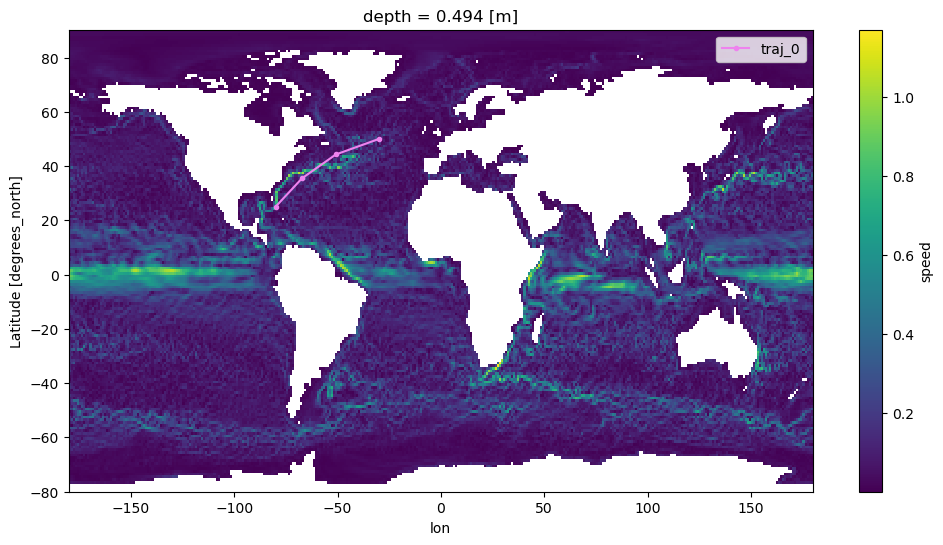

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
currents.speed.plot(ax=ax)
traj_0.data_frame.plot.line(
    x="lon", y="lat", marker=".", ax=ax, color="violet", label="traj_0"
)

In [7]:
traj_1 = Trajectory(
    lon=traj_0.lon.copy(),
    lat=traj_0.lat.copy(),
    duration_seconds=traj_0.duration_seconds,
)
cost = traj_1.estimate_cost_through(data_set=currents).sum().data[()]
accepted = 0
for n in tqdm.tqdm(range(1_000)):
    _traj_1 = move_random_node(trajectory=traj_1, max_dist_meters=500_000)
    _cost = _traj_1.estimate_cost_through(data_set=currents).sum().data[()]
    if not np.isnan(_cost) and _cost < cost:
        traj_1 = _traj_1
        cost = _cost
        accepted += 1
print(accepted)

100%|█████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 758.53it/s]

12


In [8]:
traj_2 = traj_1.refine(new_dist=500_000)
cost = traj_2.estimate_cost_through(data_set=currents).sum().data[()]
accepted = 0
for n in tqdm.tqdm(range(1_000)):
    _traj_2 = move_random_node(trajectory=traj_2, max_dist_meters=100_000)
    _cost = _traj_2.estimate_cost_through(data_set=currents).sum().data[()]
    if not np.isnan(_cost) and _cost < cost:
        traj_2 = _traj_2
        cost = _cost
        accepted += 1
print(accepted)

100%|█████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 744.01it/s]

60


In [9]:
# %pip install tqdm

In [10]:
traj_3 = traj_2.refine(new_dist=200_000)
cost = traj_3.estimate_cost_through(data_set=currents).sum().data[()]
accepted = 0
for n in tqdm.tqdm(range(1_000)):
    _traj_3 = move_random_node(trajectory=traj_3, max_dist_meters=50_000)
    _cost = _traj_2.estimate_cost_through(data_set=currents).sum().data[()]
    if not np.isnan(_cost) and _cost < cost:
        traj_3 = _traj_3
        cost = _cost
        accepted += 1
print(accepted)

100%|█████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 709.38it/s]

1


<Axes: title={'center': 'depth = 0.494 [m]'}, xlabel='lon', ylabel='Latitude [degrees_north]'>

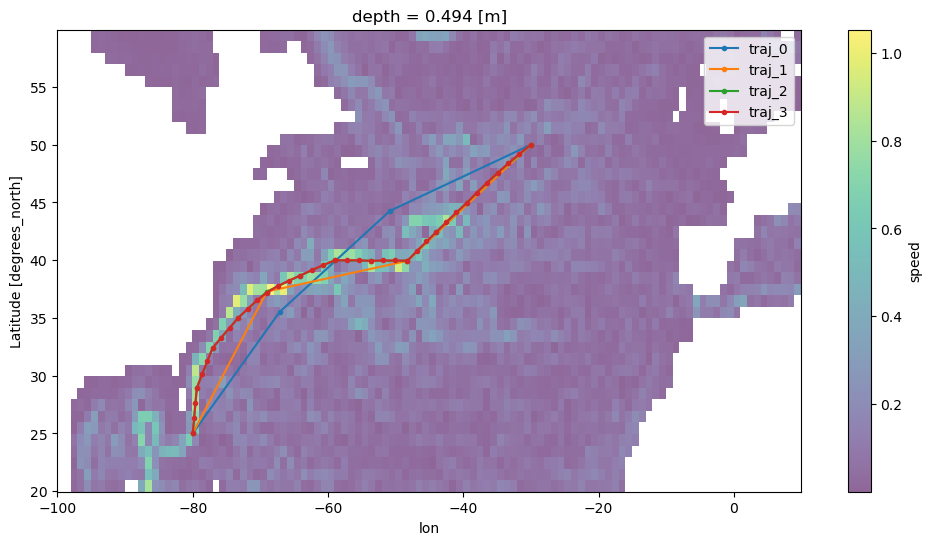

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
currents.speed.sel(lon=slice(-100, 10), lat=slice(20, 60)).plot(ax=ax, alpha=0.6)
traj_0.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="traj_0")
traj_1.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="traj_1")
traj_2.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="traj_2")
traj_3.data_frame.plot.line(x="lon", y="lat", marker=".", ax=ax, label="traj_3")